In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
from statsmodels.stats.libqsturng import qsturng
import Orange
import itertools

In [3]:
name = 'current'

Read cross-validation output for a given metric.

In [4]:
def read(how, date=name):
    return pd.read_csv('../output/{}/collection/results/crossvalidation_{}_raw_ie.csv'.format(date, how))

We'll use 7 different metrics for cross-validation.

In [5]:
#metrics = ['rmse', 'me', 'mae', 'xe', 'ef', 'ef1', 'd', 'd1', 'dr', 'm', 'r']
metrics = ['ef', 'ef1', 'd', 'd1', 'dr', 'm', 'r']

Create a dataframe from the output with given columns.

In [6]:
def load(columns, date=name):
    return pd.concat([read(m, date) for m in metrics]).set_index(['how', 'title', 'seq'])[columns]

In [7]:
def load2(columns, date=name):
    df = pd.concat([read(m, date) for m in metrics])
    df['group'] = (df.seq / 5).astype(int)
    return df.set_index(['how', 'title', 'group'])[columns]

Default functions (`load` and `rank`) treat cross-validation samples indepenently, whereas variant functions (`load2` and `rank2`) treat them as replicates.

We'll test 3 scenarios:
1. Between individual models
2. Individual models vs. an ensemble (EN)
3. Between ensemble models.

In [8]:
individuals = ['GD', 'CF', 'Beta', 'DTS', 'SF', 'TP', 'SM', 'PM', 'AM'] + ['M']
#individuals_with_ensemble = individuals + ['EN']
individuals_with_ensemble = individuals + ['EN', 'EN.rf', 'EN.rf2']
ensembles = ['EN', 'EN.d', 'EN.d1', 'EN.dr', 'EN.ef', 'EN.ef1', 'EN.m', 'EN.r', 'EN.rf', 'EN.rf2']
individuals_with_ensemble_all = individuals + ensembles

Here is a part of the dataframe for the second scenario.

In [9]:
load(individuals_with_ensemble).head()

GD         CF      Beta       DTS        SF  \
how title     seq                                                       
EF  cherry_dc 0     0.839466   0.669708  0.902769  0.939032  0.904015   
              1     0.501785   0.249883  0.709531  0.742803  0.711056   
              2     0.307813   0.034068  0.522499  0.756944  0.293122   
              3     0.403007  -0.212274 -0.086853 -2.660028 -2.108777   
              4   -17.483073 -10.821832 -9.009766 -9.584418 -4.274740   

                          TP         SM         PM         AM         M  \
how title     seq                                                         
EF  cherry_dc 0     0.704634   0.776311   0.836248   0.873599 -0.199922   
              1     0.750542  -0.010379  -0.025989   0.422338 -0.000608   
              2     0.296625   0.885657   0.882598 -18.049746 -0.009348   
              3     0.261708   0.395279   0.386689  -0.422731 -0.591007   
              4   -12.875000 -13.881510 -14.000217 -11.314236 -1.261254   

                         EN      EN.rf     EN.rf2  
how title     seq                                  
EF  cherry_dc 0    0.911805   0.840253   0.858946  
              1    0.801077   0.481683   0.746315  
              2    0.293857   0.602896   0.274562  
              3    0.246444   0.368087   0.152374  
              4   -9.081433 -13.870587 -10.558417

In [10]:
load(ensembles).head()

EN       EN.d      EN.d1     EN.dr      EN.ef  \
how title     seq                                                        
EF  cherry_dc 0    0.911805   0.933715   0.933680  0.918847   0.930619   
              1    0.801077   0.815716   0.808821  0.791040   0.785493   
              2    0.293857   0.254686   0.250892  0.291846   0.293388   
              3    0.246444   0.157468   0.154155  0.217806   0.163062   
              4   -9.081433 -10.353369 -10.335135 -9.516581 -10.335627   

                      EN.ef1       EN.m       EN.r      EN.rf     EN.rf2  
how title     seq                                                         
EF  cherry_dc 0     0.928742   0.933525   0.933686   0.840253   0.858946  
              1     0.768285   0.802119   0.799616   0.481683   0.746315  
              2     0.282314   0.275176   0.255706   0.602896   0.274562  
              3     0.154478   0.159290   0.152574   0.368087   0.152374  
              4   -10.316945 -10.335383 -10.322945 -13.870587 -10.558417

In [11]:
load2(ensembles).head()

EN       EN.d      EN.d1     EN.dr      EN.ef  \
how title     group                                                        
EF  cherry_dc 0      0.911805   0.933715   0.933680  0.918847   0.930619   
              0      0.801077   0.815716   0.808821  0.791040   0.785493   
              0      0.293857   0.254686   0.250892  0.291846   0.293388   
              0      0.246444   0.157468   0.154155  0.217806   0.163062   
              0     -9.081433 -10.353369 -10.335135 -9.516581 -10.335627   

                        EN.ef1       EN.m       EN.r      EN.rf     EN.rf2  
how title     group                                                         
EF  cherry_dc 0       0.928742   0.933525   0.933686   0.840253   0.858946  
              0       0.768285   0.802119   0.799616   0.481683   0.746315  
              0       0.282314   0.275176   0.255706   0.602896   0.274562  
              0       0.154478   0.159290   0.152574   0.368087   0.152374  
              0     -10.316945 -10.335383 -10.322945 -13.870587 -10.558417

Generate a rank out of the dataframe.

In [12]:
def rank(df):
    return df.rank(axis=1, ascending=False).groupby(level=[0,1]).mean()

In [13]:
def rank2(df):
    return df.rank(axis=1, ascending=False).groupby(level=[0,1,2]).mean()

Here is a part of the generated ranks for the second scenario.

In [14]:
rank(load(individuals_with_ensemble)).head()

GD        CF      Beta       DTS        SF  \
how title                                                                   
D   apple_kearneysville  6.509091  6.181818  6.477273  6.800000  6.509091   
    cherry_dc            7.000000  6.600000  6.300000  5.200000  6.400000   
    cherry_korea         6.769231  6.123077  6.661538  6.292308  7.153846   
    peach_korea          7.084000  5.872000  7.360000  6.298000  7.056000   
    pear_korea           6.686000  5.398000  6.744000  6.602000  7.242000   

                               TP        SM        PM        AM          M  \
how title                                                                    
D   apple_kearneysville  6.818182  8.036364  8.309091  8.513636   9.818182   
    cherry_dc            8.000000  5.900000  5.300000  9.400000  11.100000   
    cherry_korea         7.338462  6.784615  6.646154  7.538462  12.507692   
    peach_korea          7.744000  6.380000  6.720000  6.742000  11.328000   
    pear_korea           7.522000  7.012000  6.900000  6.242000  10.818000   

                               EN     EN.rf    EN.rf2  
how title                                              
D   apple_kearneysville  4.845455  6.718182  5.463636  
    cherry_dc            5.800000  7.600000  6.400000  
    cherry_korea         5.123077  6.892308  5.169231  
    peach_korea          5.536000  7.314000  5.566000  
    pear_korea           5.786000  7.700000  6.348000

In [15]:
rank(load(ensembles)).head()

EN      EN.d     EN.d1     EN.dr     EN.ef  \
how title                                                                   
D   apple_kearneysville  5.022727  4.268182  4.513636  5.177273  6.063636   
    cherry_dc            6.150000  4.850000  5.450000  5.450000  5.950000   
    cherry_korea         6.153846  4.969231  5.246154  5.600000  5.261538   
    peach_korea          6.080000  4.928000  4.928000  5.844000  5.370000   
    pear_korea           5.806000  4.862000  4.558000  5.542000  5.990000   

                           EN.ef1      EN.m      EN.r     EN.rf    EN.rf2  
how title                                                                  
D   apple_kearneysville  6.209091  5.540909  5.177273  6.586364  6.440909  
    cherry_dc            5.650000  4.750000  4.850000  5.650000  6.250000  
    cherry_korea         5.476923  5.000000  5.292308  6.569231  5.430769  
    peach_korea          5.702000  4.676000  4.964000  7.080000  5.428000  
    pear_korea           5.766000  4.990000  4.698000  6.998000  5.790000

In [16]:
rank2(load2(individuals_with_ensemble)).head()

GD   CF  Beta  DTS   SF   TP   SM   PM    AM  \
how title               group                                                  
D   apple_kearneysville 0      7.2  5.8   7.8  6.6  4.0  6.6  8.8  7.8   8.0   
                        1      9.8  3.2   8.2  9.0  6.8  5.2  7.2  7.6  10.6   
                        2      5.8  5.4   6.8  6.4  6.4  6.0  9.3  9.9   9.2   
                        3      6.0  7.4   6.2  6.4  6.6  4.6  8.9  9.1   7.2   
                        4      8.0  5.6   7.6  8.8  8.2  4.8  7.6  7.2   8.0   

                                  M   EN  EN.rf  EN.rf2  
how title               group                            
D   apple_kearneysville 0      12.2  4.4    6.6     5.2  
                        1      10.8  3.0    6.0     3.6  
                        2      10.2  4.0    6.6     5.0  
                        3       9.8  5.2    8.0     5.6  
                        4      11.2  3.8    6.6     3.6

Now we have 3 rank dataframes for each scenario.

Average across all datasets, giving one sample per model.

In [17]:
rii = rank(load(individuals))
rie = rank(load(individuals_with_ensemble))
ree = rank(load(ensembles))
rall = rank(load(individuals_with_ensemble_all))

In [18]:
#rii.to_csv('rii.csv')
#rie.to_csv('rie.csv')
#ree.to_csv('ree.csv')
#rall.to_csv('rall.csv)

Make an individual sample by different species, but merge replicates from crossvalidation.

In [19]:
rii2 = rank2(load2(individuals))
rie2 = rank2(load2(individuals_with_ensemble))
ree2 = rank2(load2(ensembles))
rall2 = rank2(load2(individuals_with_ensemble_all))

Count crossvalidation as an individual sample.

In [20]:
rii3 = rank2(load(individuals))
rie3 = rank2(load(individuals_with_ensemble))
ree3 = rank2(load(ensembles))
rall3 = rank2(load(individuals_with_ensemble_all))

Conduct Friedman test on the rank dataframe.

In [21]:
def friedman(rdf, how):
    return st.friedmanchisquare(*rdf.loc[how].as_matrix().T)

In [22]:
def friedmans(rdf):
    return pd.DataFrame({h: friedman(rdf, h) for h in hows}, index=['statistic', 'pvalue'])

Friedman test over individual models for Willmot's refined index of agreement (Dr) turns out to be non-significant (p=0.08).

In [23]:
friedman(rii, 'DR')

FriedmanchisquareResult(statistic=31.560000000000002, pvalue=0.0002371731686279505)

In [24]:
friedman(rii2, 'DR')

FriedmanchisquareResult(statistic=228.3453352964797, pvalue=3.6699796865340437e-44)

On the other hand, Friedman test over individuals with an ensemble model turns out to be significant (p=0.01) that there is a difference between models, in this case, due to the just added ensemble model.

In [25]:
friedman(rie, 'DR')

FriedmanchisquareResult(statistic=46.760439560439579, pvalue=5.1285864092948891e-06)

In [26]:
friedman(rie2, 'DR')

FriedmanchisquareResult(statistic=470.7652499848856, pvalue=3.6609999240352882e-93)

Meanwhile, Friedman test over different ensemble models turns out to be highly non-significant (p=0.65), so we can't tell there is a difference in performance between them.

In [27]:
friedman(ree, 'DR')

FriedmanchisquareResult(statistic=27.613885505481139, pvalue=0.0011063208066468856)

In [28]:
friedman(ree2, 'DR')

FriedmanchisquareResult(statistic=279.90594259533742, pvalue=4.7359675166290675e-55)

Here is a summary over all metrics.

Friedman tests over individual models. They are all non-significant at p=0.05.

In [29]:
hows = rii.index.levels[0]
hows

Index(['D', 'D1', 'DR', 'EF', 'EF1', 'M', 'R'], dtype='object', name='how')

In [30]:
friedmans(rii)

,D,D1,DR,EF,EF1,M,R
statistic,25.669091,29.599515,31.560000,32.408759,31.560000,23.879562,25.184690
pvalue,0.002314,0.000513,0.000237,0.000169,0.000237,0.004496,0.002774


In [31]:
friedmans(rii2)

,D,D1,DR,EF,EF1,M,R
statistic,3.171514e+02,3.104115e+02,2.283453e+02,2.115764e+02,2.283453e+02,3.275510e+02,3.158537e+02
pvalue,5.974005e-63,1.612001e-61,3.669980e-44,1.233460e-40,3.669980e-44,3.687668e-65,1.126863e-62


In [32]:
friedmans(rank2(load2(['GD', 'CF', 'Beta'])))

,D,D1,DR,EF,EF1,M,R
statistic,3.114919e+01,11.143418,2.521569,1.821359,2.521569,3.102924e+01,18.003945
pvalue,1.722021e-07,0.003804,0.283432,0.402251,0.283432,1.828463e-07,0.000123


Friedman tests over individual models with an ensemble model. They are all significant at p=0.01.

In [33]:
friedmans(rie)

,D,D1,DR,EF,EF1,M,R
statistic,41.207921,43.234323,46.760440,47.082003,46.760440,39.421024,39.797802
pvalue,0.000045,0.000021,0.000005,0.000005,0.000005,0.000090,0.000078


In [34]:
friedmans(rie2)

,D,D1,DR,EF,EF1,M,R
statistic,4.517790e+02,4.601621e+02,4.707652e+02,4.692370e+02,4.707652e+02,4.402821e+02,4.377042e+02
pvalue,3.957411e-89,6.558298e-91,3.661000e-93,7.734465e-93,3.661000e-93,1.091999e-86,3.848604e-86


Friedman test over ensemble models. Most of them are highly non-significant, but there are a couple that indicates significance.

In [35]:
friedmans(ree)

,D,D1,DR,EF,EF1,M,R
statistic,31.960976,30.186813,27.613886,30.453106,27.613886,30.739976,26.367273
pvalue,0.000202,0.000408,0.001106,0.000367,0.001106,0.000328,0.001778


In [36]:
friedmans(ree2)

,D,D1,DR,EF,EF1,M,R
statistic,1.977522e+02,1.908840e+02,2.799059e+02,2.961251e+02,2.799059e+02,1.902938e+02,1.898067e+02
pvalue,9.801986e-38,2.688817e-36,4.735968e-55,1.731775e-58,4.735968e-55,3.573214e-36,4.518339e-36


Look at the difference between averaged ranks.

In [37]:
rii2.groupby(level='how').mean()

,GD,CF,Beta,DTS,SF,TP,SM,PM,AM,M
how,,,,,,,,,,
D,5.165693,4.399270,5.248905,4.922628,5.287591,5.651825,5.241606,5.315328,5.305839,8.461314
D1,5.035036,4.537956,5.221898,4.919708,5.284672,5.702190,5.207299,5.371533,5.435766,8.283942
DR,4.956934,5.081022,5.156204,4.326277,5.017518,5.698540,5.775912,5.912409,6.162044,6.913139
EF,4.978467,5.116788,5.144526,4.280292,5.001460,5.710219,5.798175,5.943066,6.195620,6.831387
EF1,4.928467,5.083212,5.147993,4.300912,5.006204,5.692336,5.782482,5.930657,6.188504,6.939234
M,5.262774,4.358394,5.228467,4.983942,5.332117,5.695620,5.135036,5.207299,5.251095,8.545255
R,5.140876,4.489051,5.171533,4.981022,5.327007,5.605109,5.243796,5.293431,5.346715,8.401460


In [38]:
rii2.mean(axis=0).sort_values()

DTS     4.673540
CF      4.723670
GD      5.066893
SF      5.179510
Beta    5.188504
SM      5.454901
PM      5.567675
TP      5.679406
AM      5.697941
M       7.767961
dtype: float64

Calculate critial difference for Nemenyi test.

In [39]:
def critical_value(p, k):
    return qsturng(1-p, k, np.inf) / np.sqrt(2)

def critical_difference(p, k, n):
    return critical_value(p, k) * np.sqrt((k*(k+1)) / (6*n))

In [40]:
critical_difference(0.05, 4, 5)

2.0975924614902377

In [41]:
critical_difference(0.05, 5, 5)

2.7277508838690383

In [42]:
critical_difference(0.05, 8, 5)

4.6953889282071719

In [43]:
critical_difference(0.05, 4, 137)

0.40072444135775453

In [44]:
critical_difference(0.10, 4, 137)

0.35739849198748025

In [45]:
critical_difference(0.05, 5, 137)

0.52111001978189975

In [46]:
critical_difference(0.05, 8, 137)

0.89700794589834176

In [47]:
def plot_ranks(rdf, how, p=0.05, mark=None, lowv=None, highv=None, **kwargs):
    df = rdf.loc[how]
    s = df.mean(axis=0)
    cd = critical_difference(p, len(s), len(df))
    Orange.evaluation.graph_ranks(s, s.index, cd, mark, lowv=lowv, highv=highv, **kwargs)

In [48]:
#plot_ranks(rii2, 'DR')

In [49]:
def plot_ranks_all(rdf, p=0.05, mark=None, lowv=None, highv=None, filename=None, **kwargs):
    hows = rdf.index.levels[0]
    print(hows)
    for how in hows:
        plot_ranks(rdf, how, p, mark, lowv, highv, filename=filename.format(how), **kwargs)

Index(['D', 'D1', 'DR', 'EF', 'EF1', 'M', 'R'], dtype='object', name='how')


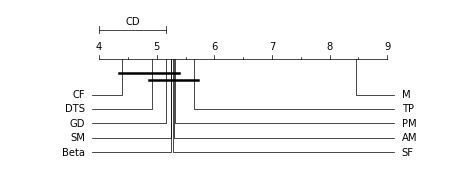

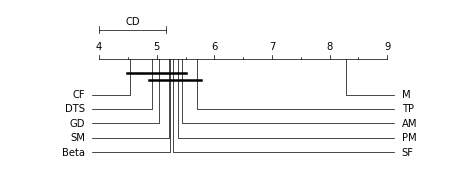

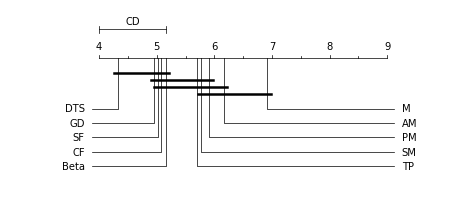

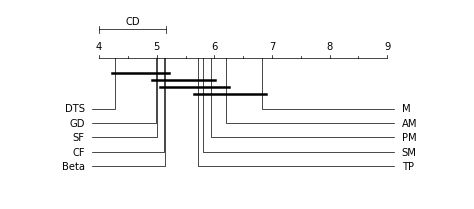

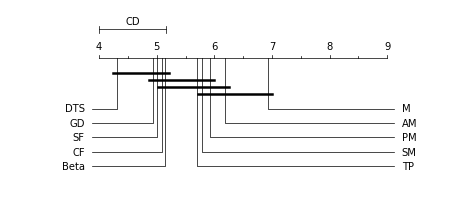

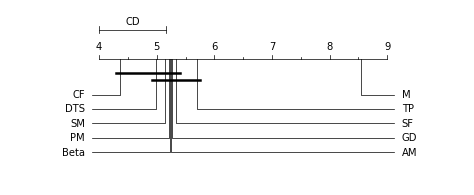

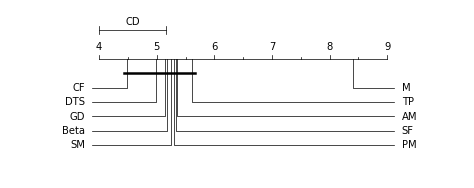

In [50]:
plot_ranks_all(rii2, lowv=4, highv=9, filename='rii2_{}.png', dpi=300)

Index(['D', 'D1', 'DR', 'EF', 'EF1', 'M', 'R'], dtype='object', name='how')


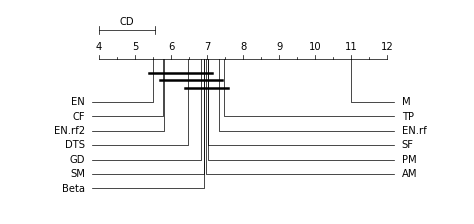

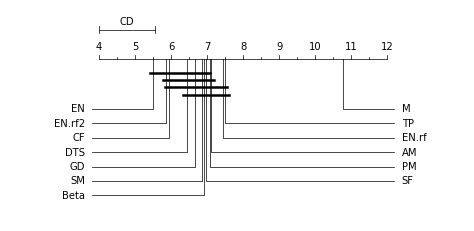

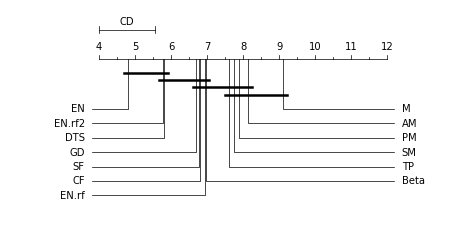

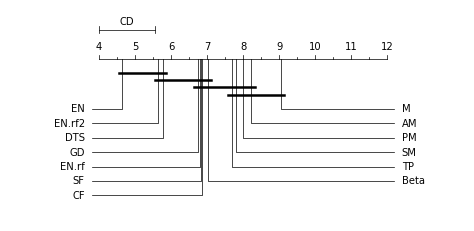

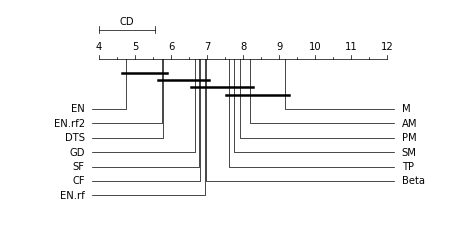

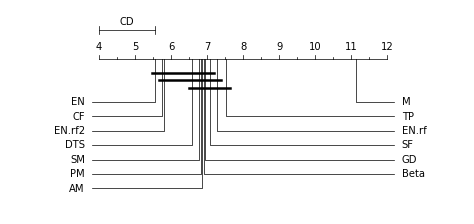

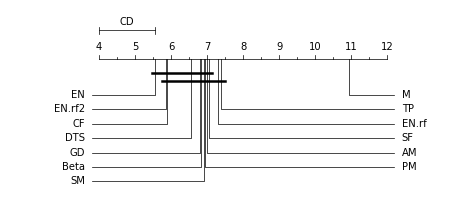

In [51]:
plot_ranks_all(rie2, lowv=4, highv=12, filename='rie2_{}.png', dpi=300)

Index(['D', 'D1', 'DR', 'EF', 'EF1', 'M', 'R'], dtype='object', name='how')


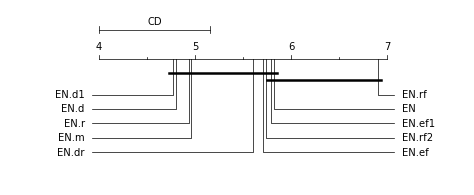

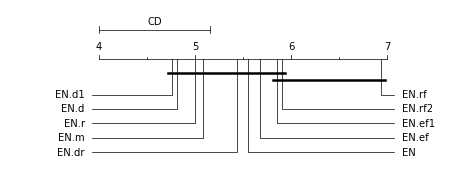

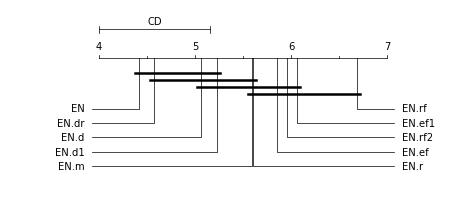

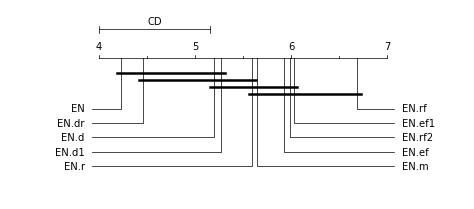

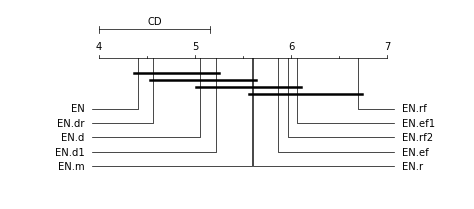

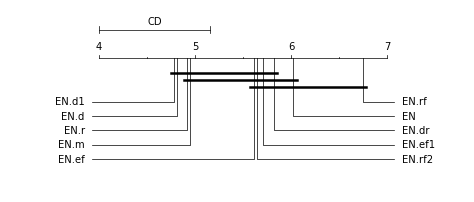

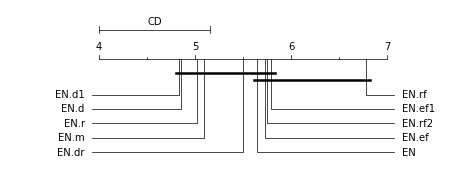

In [52]:
plot_ranks_all(ree2, lowv=4, highv=7, filename='ree2_{}.png', dpi=300)

Index(['D', 'D1', 'DR', 'EF', 'EF1', 'M', 'R'], dtype='object', name='how')


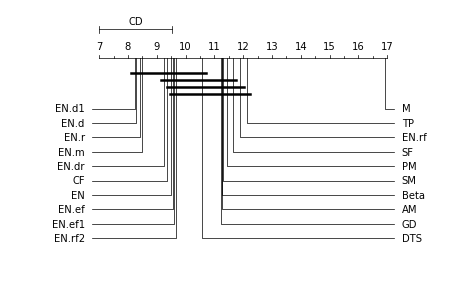

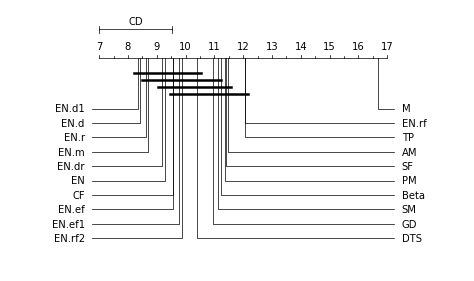

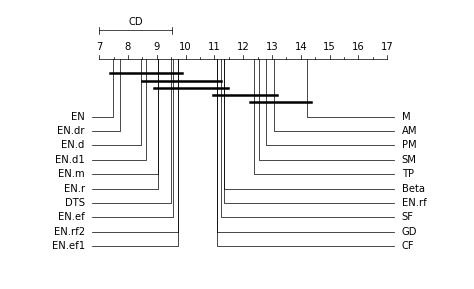

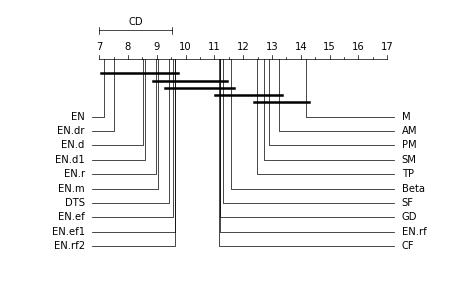

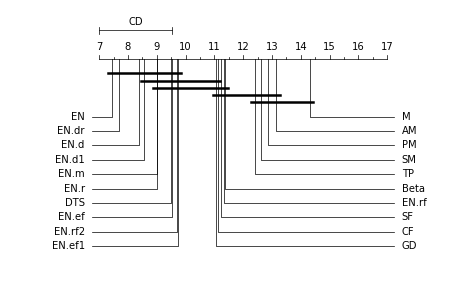

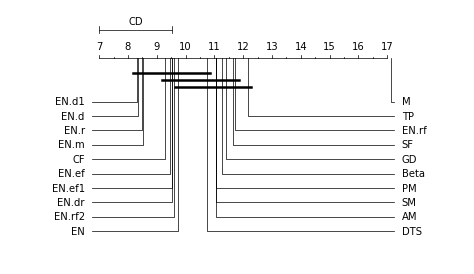

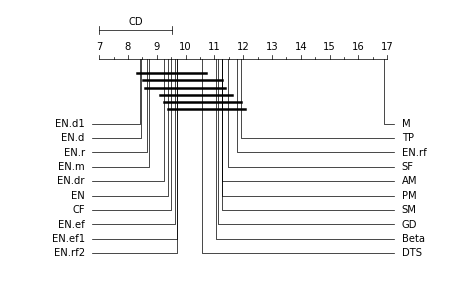

In [53]:
plot_ranks_all(rall2, lowv=7, highv=17, filename='rall2_{}.png', dpi=300)

Index(['D', 'D1', 'DR', 'EF', 'EF1', 'M', 'R'], dtype='object', name='how')


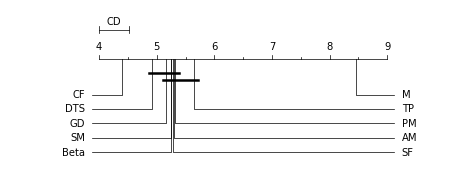

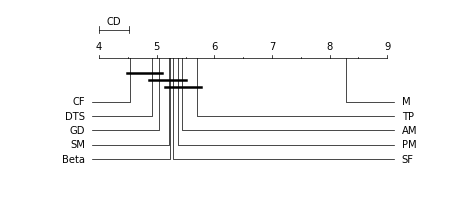

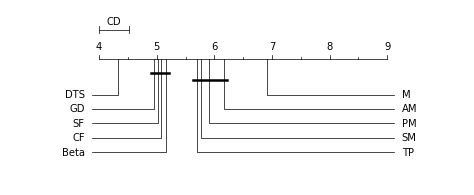

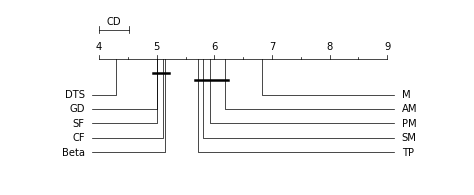

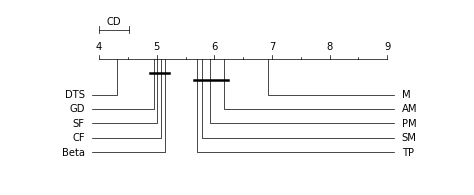

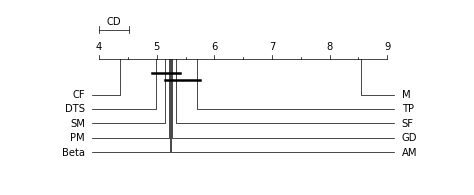

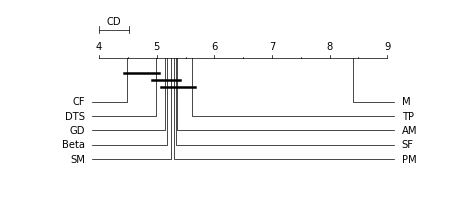

In [54]:
plot_ranks_all(rii3, lowv=4, highv=9, filename='rii3_{}.png', dpi=300)

Index(['D', 'D1', 'DR', 'EF', 'EF1', 'M', 'R'], dtype='object', name='how')


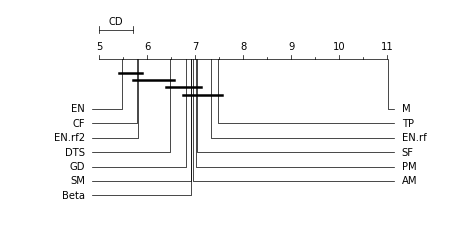

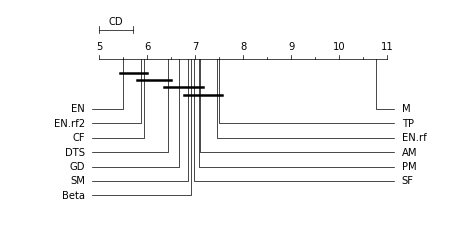

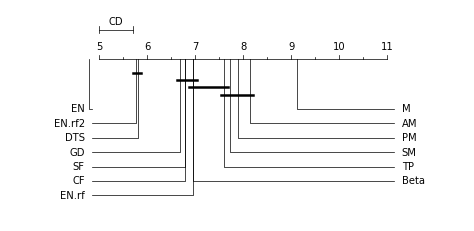

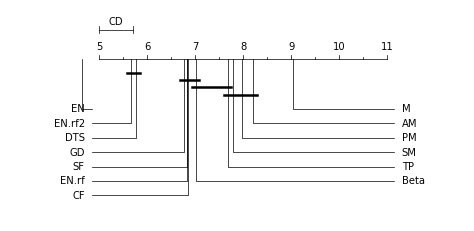

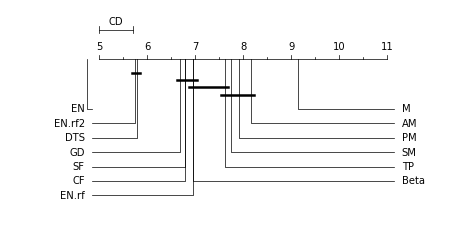

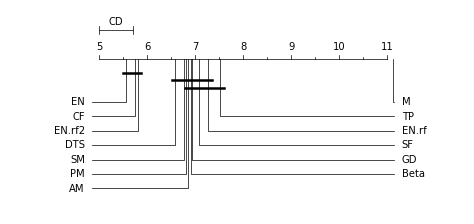

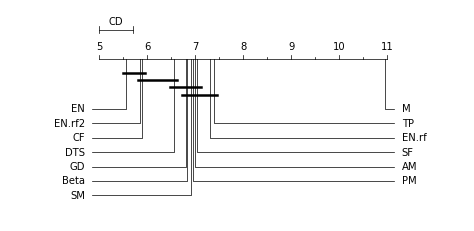

In [55]:
plot_ranks_all(rie3, lowv=5, highv=11, filename='rie3_{}.png', dpi=300)

Index(['D', 'D1', 'DR', 'EF', 'EF1', 'M', 'R'], dtype='object', name='how')


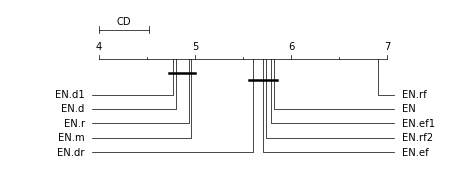

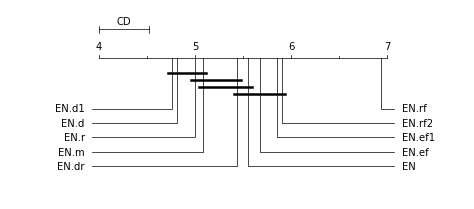

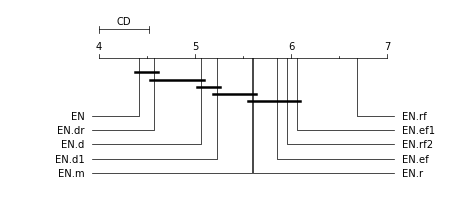

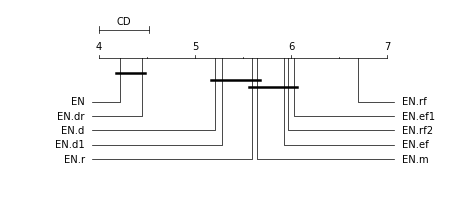

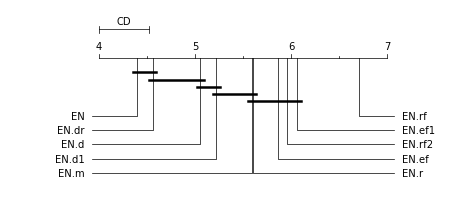

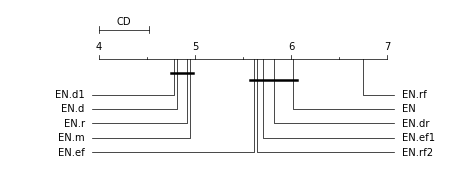

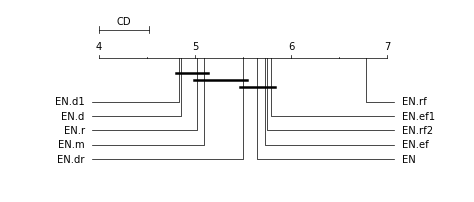

In [56]:
plot_ranks_all(ree3, lowv=4, highv=7, filename='ree3_{}.png', dpi=300)

Index(['D', 'D1', 'DR', 'EF', 'EF1', 'M', 'R'], dtype='object', name='how')


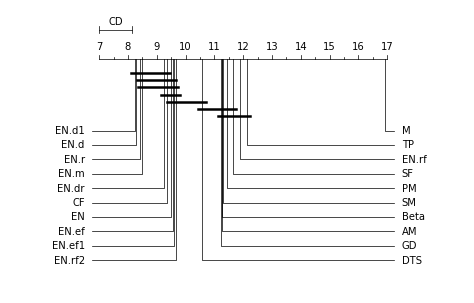

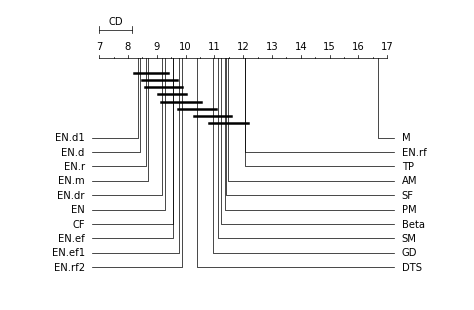

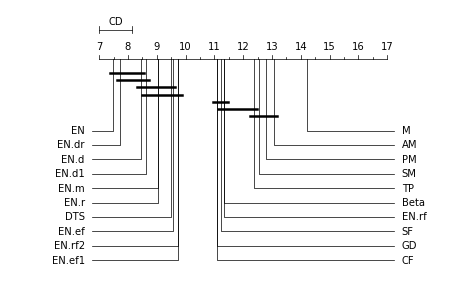

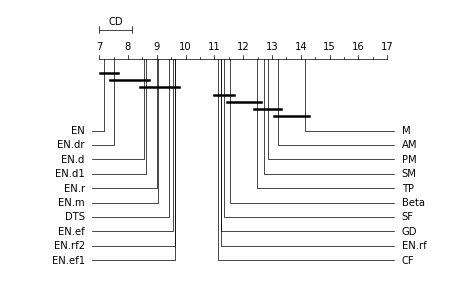

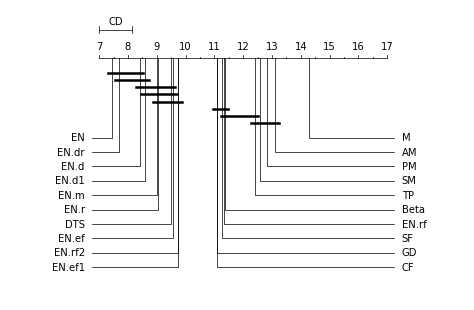

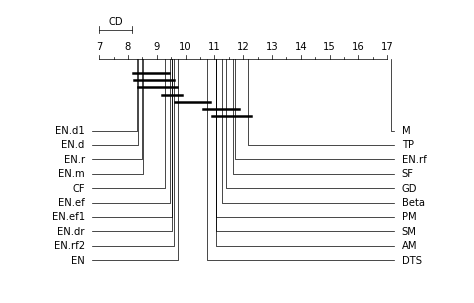

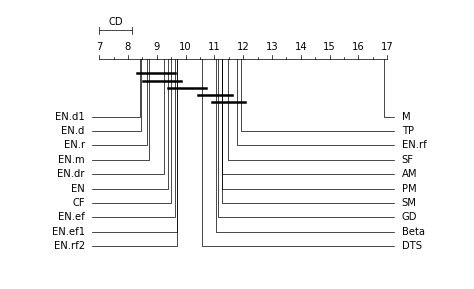

In [57]:
plot_ranks_all(rall3, lowv=7, highv=17, filename='rall3_{}.png', dpi=300)

Implement Nemenyi test.

In [58]:
def nemenyi(rdf, how, p=0.05, boolean=True):
    df = rdf.loc[how]
    s = df.mean(axis=0)
    C = list(itertools.combinations(s.index, 2))
    cd = critical_difference(p, len(s), len(df))
    if boolean:
        return pd.Series({"{}-{}".format(b, a): abs(s[b] - s[a]) > cd for (a, b) in C})
    else:
        r = pd.Series({"{}-{}".format(b, a): s[b] - s[a] for (a, b) in C})
        r['critical difference'] = cd
        return r

In [59]:
def nemenyis(rdf, p=0.05, boolean=True):
    return pd.DataFrame({h: nemenyi(rdf, h, p, boolean) for h in hows})

In [60]:
nemenyi(rii2, 'DR')

AM-Beta     False
AM-CF       False
AM-DTS       True
AM-GD        True
AM-PM       False
AM-SF       False
AM-SM       False
AM-TP       False
Beta-CF     False
Beta-GD     False
CF-GD       False
DTS-Beta    False
DTS-CF      False
DTS-GD      False
M-AM        False
M-Beta       True
M-CF         True
M-DTS        True
M-GD         True
M-PM        False
M-SF         True
M-SM        False
M-TP         True
PM-Beta     False
PM-CF       False
PM-DTS       True
PM-GD       False
PM-SF       False
PM-SM       False
PM-TP       False
SF-Beta     False
SF-CF       False
SF-DTS      False
SF-GD       False
SM-Beta     False
SM-CF       False
SM-DTS       True
SM-GD       False
SM-SF       False
SM-TP       False
TP-Beta     False
TP-CF       False
TP-DTS       True
TP-GD       False
TP-SF       False
dtype: bool

In [61]:
nemenyi(rii2, 'DR', boolean=False)

AM-Beta                1.005839
AM-CF                  1.081022
AM-DTS                 1.835766
AM-GD                  1.205109
AM-PM                  0.249635
AM-SF                  1.144526
AM-SM                  0.386131
AM-TP                  0.463504
Beta-CF                0.075182
Beta-GD                0.199270
CF-GD                  0.124088
DTS-Beta              -0.829927
DTS-CF                -0.754745
DTS-GD                -0.630657
M-AM                   0.751095
M-Beta                 1.756934
M-CF                   1.832117
M-DTS                  2.586861
M-GD                   1.956204
M-PM                   1.000730
M-SF                   1.895620
M-SM                   1.137226
M-TP                   1.214599
PM-Beta                0.756204
PM-CF                  0.831387
PM-DTS                 1.586131
PM-GD                  0.955474
PM-SF                  0.894891
PM-SM                  0.136496
PM-TP                  0.213869
SF-Beta               -0.138686
SF-CF   

In [62]:
nemenyis(rii2, p=0.05)

,D,D1,DR,EF,EF1,M,R
AM-Beta,False,False,False,False,False,False,False
AM-CF,False,False,False,False,False,False,False
AM-DTS,False,False,True,True,True,False,False
AM-GD,False,False,True,True,True,False,False
AM-PM,False,False,False,False,False,False,False
AM-SF,False,False,False,True,True,False,False
AM-SM,False,False,False,False,False,False,False
AM-TP,False,False,False,False,False,False,False
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False


In [63]:
nemenyis(rii2, p=0.05, boolean=False)

,D,D1,DR,EF,EF1,M,R
AM-Beta,0.056934,0.213869,1.005839,1.051095,1.040511,0.022628,0.175182
AM-CF,0.906569,0.897810,1.081022,1.078832,1.105292,0.892701,0.857664
AM-DTS,0.383212,0.516058,1.835766,1.915328,1.887591,0.267153,0.365693
AM-GD,0.140146,0.400730,1.205109,1.217153,1.260036,-0.011679,0.205839
AM-PM,-0.009489,0.064234,0.249635,0.252555,0.257847,0.043796,0.053285
AM-SF,0.018248,0.151095,1.144526,1.194161,1.182299,-0.081022,0.019708
AM-SM,0.064234,0.228467,0.386131,0.397445,0.406022,0.116058,0.102920
AM-TP,-0.345985,-0.266423,0.463504,0.485401,0.496168,-0.444526,-0.258394
Beta-CF,0.849635,0.683942,0.075182,0.027737,0.064781,0.870073,0.682482
Beta-GD,0.083212,0.186861,0.199270,0.166058,0.219526,-0.034307,0.030657


DR metric indicated that DTS was significantly better than Beta. EF metric indicated that DTS was significantly better than CF and Beta. But, no metric could show significant difference between DTS and GD. Also, there was no significance reported by other five metrics at all. All tests were conducted at p=0.05 level.

In [64]:
rii2

GD   CF  Beta  DTS   SF   TP   SM   PM   AM  \
how title               group                                                 
D   apple_kearneysville 0      5.6  4.0   5.4  5.0  2.8  5.4  6.0  5.4  6.2   
                        1      7.2  2.0   5.6  6.2  4.2  3.6  5.2  5.2  7.8   
                        2      4.2  3.6   4.8  4.8  4.4  4.2  6.9  7.5  6.8   
                        3      4.7  5.7   4.9  5.1  5.1  3.5  6.6  6.4  5.3   
                        4      5.5  3.9   5.7  6.1  5.7  3.3  5.5  5.3  5.5   
                        5      4.8  3.2   5.6  5.6  4.6  4.2  6.4  7.8  6.8   
                        6      5.1  5.7   6.1  4.1  4.7  5.3  4.8  5.8  6.3   
                        7      4.1  3.5   4.7  4.9  5.9  6.5  6.7  5.7  6.1   
                        8      5.4  4.4   3.9  5.4  4.8  6.2  7.0  5.9  5.1   
                        9      4.5  5.5   6.1  4.7  4.1  5.9  6.1  4.1  6.5   
                        10     4.5  5.3   6.1  5.3  5.1  5.9  6.1  4.1  5.3   
                        11     3.4  6.0   4.0  2.0  4.2  8.0  6.7  7.5  5.8   
                        12     5.1  4.7   5.1  4.9  4.3  4.5  5.7  6.3  6.1   
                        13     6.0  4.1   3.6  5.4  5.0  6.0  5.9  6.5  6.3   
                        14     2.6  5.6   3.4  5.4  4.6  5.4  5.0  5.8  9.0   
                        15     5.1  2.7   6.1  4.9  5.7  3.9  4.5  7.3  6.1   
                        16     6.0  2.6   3.0  5.4  5.4  5.0  6.0  6.4  7.0   
                        17     5.2  5.0   5.6  4.6  5.0  4.6  5.9  5.7  6.2   
                        18     3.9  7.1   3.7  5.9  5.7  4.5  4.6  5.0  7.3   
                        19     6.0  3.4   3.8  4.6  6.4  5.8  5.2  5.8  6.4   
                        20     5.5  3.5   4.4  6.6  3.8  4.7  5.2  7.7  5.6   
                        21     3.5  5.3   6.0  4.1  4.9  4.5  7.3  8.0  6.7   
    cherry_dc           0      5.9  6.5   4.0  4.7  5.0  4.4  5.1  5.3  6.1   
                        1      5.2  3.8   5.6  3.6  4.8  8.0  4.0  3.2  8.0   
    cherry_korea        0      6.4  5.0   5.2  5.6  5.6  7.2  5.2  2.4  2.6   
                        1      6.8  3.8   3.6  6.6  3.4  5.0  5.6  6.0  4.2   
                        2      4.8  3.2   4.6  4.4  6.0  4.0  6.2  8.0  3.8   
                        3      4.2  4.8   4.0  3.6  3.4  7.8  4.6  6.2  6.4   
                        4      5.8  4.0   7.2  4.8  6.0  3.4  3.8  4.2  6.4   
                        5      4.6  3.8   3.4  4.6  6.0  4.6  6.4  6.8  5.4   
...                            ...  ...   ...  ...  ...  ...  ...  ...  ...   
R   pear_korea          20     6.8  2.4   6.2  3.8  5.6  6.2  4.2  4.0  7.0   
                        21     4.2  4.4   4.8  5.2  4.0  5.6  7.0  5.8  5.8   
                        22     5.6  4.6   6.1  5.1  4.7  4.5  7.0  6.7  3.5   
                        23     6.2  5.8   5.2  5.2  5.4  4.6  5.8  4.8  5.4   
                        24     5.2  4.8   4.3  5.4  6.2  5.4  5.6  6.6  3.6   
                        25     6.2  3.6   4.4  4.8  6.0  6.4  4.6  5.8  5.0   
                        26     6.6  4.6   5.0  4.0  5.2  4.5  6.0  6.8  6.8   
                        27     5.0  2.2   4.6  6.6  7.4  1.6  5.8  6.6  5.6   
                        28     3.8  5.4   4.6  5.0  4.2  5.5  5.4  6.6  4.8   
                        29     5.4  4.2   6.2  7.0  6.2  6.4  4.6  4.8  3.4   
                        30     5.9  5.5   5.3  5.9  4.7  5.2  4.3  5.1  6.1   
                        31     3.9  3.4   5.1  4.6  5.3  7.9  5.9  5.7  5.3   
                        32     5.8  3.6   6.4  3.0  8.0  5.6  5.2  6.8  3.2   
                        33     5.0  2.8   5.8  5.6  7.2  5.2  5.6  4.4  3.6   
                        34     4.6  5.0   6.0  4.4  6.4  5.6  5.0  5.0  4.2   
                        35     6.8  2.8   3.8  5.8  5.2  7.1  4.0  7.4  5.4   
                        36     6.6  5.2   5.2  4.8  4.4  7.6  3.0  2.8  5.4   
                        37     5.2  5.6   5.2  4.8  4.6  6.3  4.4  3.6  6.0   
   

In [65]:
nemenyis(rii2, p=0.10)

,D,D1,DR,EF,EF1,M,R
AM-Beta,False,False,False,False,False,False,False
AM-CF,False,False,True,True,True,False,False
AM-DTS,False,False,True,True,True,False,False
AM-GD,False,False,True,True,True,False,False
AM-PM,False,False,False,False,False,False,False
AM-SF,False,False,True,True,True,False,False
AM-SM,False,False,False,False,False,False,False
AM-TP,False,False,False,False,False,False,False
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False


In [66]:
nemenyis(rii2, p=0.10, boolean=False)

,D,D1,DR,EF,EF1,M,R
AM-Beta,0.056934,0.213869,1.005839,1.051095,1.040511,0.022628,0.175182
AM-CF,0.906569,0.897810,1.081022,1.078832,1.105292,0.892701,0.857664
AM-DTS,0.383212,0.516058,1.835766,1.915328,1.887591,0.267153,0.365693
AM-GD,0.140146,0.400730,1.205109,1.217153,1.260036,-0.011679,0.205839
AM-PM,-0.009489,0.064234,0.249635,0.252555,0.257847,0.043796,0.053285
AM-SF,0.018248,0.151095,1.144526,1.194161,1.182299,-0.081022,0.019708
AM-SM,0.064234,0.228467,0.386131,0.397445,0.406022,0.116058,0.102920
AM-TP,-0.345985,-0.266423,0.463504,0.485401,0.496168,-0.444526,-0.258394
Beta-CF,0.849635,0.683942,0.075182,0.027737,0.064781,0.870073,0.682482
Beta-GD,0.083212,0.186861,0.199270,0.166058,0.219526,-0.034307,0.030657


The ensemble model (EN) was significantly better than Beta and GD in all metrics. Three metrics, DR, EF, and EF1, reported significant difference against CF. Two metrics, D and M, reported significant difference against DTS. (p=0.05).

In [67]:
nemenyis(rie2, p=0.05)

,D,D1,DR,EF,EF1,M,R
AM-Beta,False,False,False,False,False,False,False
AM-CF,False,False,False,False,False,False,False
AM-DTS,False,False,True,True,True,False,False
AM-GD,False,False,False,False,False,False,False
AM-PM,False,False,False,False,False,False,False
AM-SF,False,False,False,False,False,False,False
AM-SM,False,False,False,False,False,False,False
AM-TP,False,False,False,False,False,False,False
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False


In [68]:
nemenyis(rie2, p=0.05, boolean=False)

,D,D1,DR,EF,EF1,M,R
AM-Beta,0.046715,0.187591,1.179562,1.217153,1.223723,-0.064964,0.151825
AM-CF,1.175182,1.163504,1.347445,1.376277,1.376825,1.102190,1.107299
AM-DTS,0.485401,0.664964,2.336496,2.468978,2.406204,0.272993,0.432847
AM-GD,0.143066,0.431387,1.443066,1.492336,1.515146,-0.082482,0.188321
AM-PM,-0.054745,0.020438,0.243796,0.244891,0.255292,0.038686,0.037956
AM-SF,-0.077372,0.124088,1.351825,1.410584,1.401642,-0.231387,-0.051095
AM-SM,0.050365,0.243796,0.402190,0.431752,0.425365,0.092701,0.084672
AM-TP,-0.521168,-0.397810,0.529197,0.553285,0.568796,-0.669343,-0.394891
Beta-CF,1.128467,0.975912,0.167883,0.159124,0.153102,1.167153,0.955474
Beta-GD,0.096350,0.243796,0.263504,0.275182,0.291423,-0.017518,0.036496


In [69]:
nemenyis(rie2, p=0.10)

,D,D1,DR,EF,EF1,M,R
AM-Beta,False,False,False,False,False,False,False
AM-CF,False,False,False,False,False,False,False
AM-DTS,False,False,True,True,True,False,False
AM-GD,False,False,False,True,True,False,False
AM-PM,False,False,False,False,False,False,False
AM-SF,False,False,False,False,False,False,False
AM-SM,False,False,False,False,False,False,False
AM-TP,False,False,False,False,False,False,False
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False


In [70]:
nemenyis(rie2, p=0.10, boolean=False)

,D,D1,DR,EF,EF1,M,R
AM-Beta,0.046715,0.187591,1.179562,1.217153,1.223723,-0.064964,0.151825
AM-CF,1.175182,1.163504,1.347445,1.376277,1.376825,1.102190,1.107299
AM-DTS,0.485401,0.664964,2.336496,2.468978,2.406204,0.272993,0.432847
AM-GD,0.143066,0.431387,1.443066,1.492336,1.515146,-0.082482,0.188321
AM-PM,-0.054745,0.020438,0.243796,0.244891,0.255292,0.038686,0.037956
AM-SF,-0.077372,0.124088,1.351825,1.410584,1.401642,-0.231387,-0.051095
AM-SM,0.050365,0.243796,0.402190,0.431752,0.425365,0.092701,0.084672
AM-TP,-0.521168,-0.397810,0.529197,0.553285,0.568796,-0.669343,-0.394891
Beta-CF,1.128467,0.975912,0.167883,0.159124,0.153102,1.167153,0.955474
Beta-GD,0.096350,0.243796,0.263504,0.275182,0.291423,-0.017518,0.036496


There was no single incidence reported by all metrics that any ensemble model significantly outperformed (at p=0.05).

In [71]:
nemenyis(ree2, p=0.05)

,D,D1,DR,EF,EF1,M,R
EN.d-EN,False,False,False,False,False,True,False
EN.d1-EN,False,False,False,False,False,True,False
EN.d1-EN.d,False,False,False,False,False,False,False
EN.dr-EN,False,False,False,False,False,False,False
EN.dr-EN.d,False,False,False,False,False,False,False
EN.dr-EN.d1,False,False,False,False,False,False,False
EN.ef-EN,False,False,True,True,True,False,False
EN.ef-EN.d,False,False,False,False,False,False,False
EN.ef-EN.d1,False,False,False,False,False,False,False
EN.ef-EN.dr,False,False,True,True,True,False,False


In [72]:
nemenyis(ree2, p=0.05, boolean=False)

,D,D1,DR,EF,EF1,M,R
EN.d-EN,-1.017518,-0.740146,0.649635,0.971168,0.641241,-1.210949,-0.797080
EN.d1-EN,-1.054015,-0.800000,0.816058,1.050000,0.809124,-1.240876,-0.813869
EN.d1-EN.d,-0.036496,-0.059854,0.166423,0.078832,0.167883,-0.029927,-0.016788
EN.dr-EN,-0.220438,-0.115328,0.162044,0.230657,0.159124,-0.203650,-0.146715
EN.dr-EN.d,0.797080,0.624818,-0.487591,-0.740511,-0.482117,1.007299,0.650365
EN.dr-EN.d1,0.833577,0.684672,-0.654015,-0.819343,-0.650000,1.037226,0.667153
EN.ef-EN,-0.112409,0.122628,1.445255,1.699270,1.455474,-0.411679,0.082482
EN.ef-EN.d,0.905109,0.862774,0.795620,0.728102,0.814234,0.799270,0.879562
EN.ef-EN.d1,0.941606,0.922628,0.629197,0.649270,0.646350,0.829197,0.896350
EN.ef-EN.dr,0.108029,0.237956,1.283212,1.468613,1.296350,-0.208029,0.229197


In [73]:
nemenyis(ree2, p=0.10)

,D,D1,DR,EF,EF1,M,R
EN.d-EN,False,False,False,False,False,True,False
EN.d1-EN,False,False,False,False,False,True,False
EN.d1-EN.d,False,False,False,False,False,False,False
EN.dr-EN,False,False,False,False,False,False,False
EN.dr-EN.d,False,False,False,False,False,False,False
EN.dr-EN.d1,False,False,False,False,False,False,False
EN.ef-EN,False,False,True,True,True,False,False
EN.ef-EN.d,False,False,False,False,False,False,False
EN.ef-EN.d1,False,False,False,False,False,False,False
EN.ef-EN.dr,False,False,True,True,True,False,False


In [74]:
nemenyis(ree2, p=0.10, boolean=False)

,D,D1,DR,EF,EF1,M,R
EN.d-EN,-1.017518,-0.740146,0.649635,0.971168,0.641241,-1.210949,-0.797080
EN.d1-EN,-1.054015,-0.800000,0.816058,1.050000,0.809124,-1.240876,-0.813869
EN.d1-EN.d,-0.036496,-0.059854,0.166423,0.078832,0.167883,-0.029927,-0.016788
EN.dr-EN,-0.220438,-0.115328,0.162044,0.230657,0.159124,-0.203650,-0.146715
EN.dr-EN.d,0.797080,0.624818,-0.487591,-0.740511,-0.482117,1.007299,0.650365
EN.dr-EN.d1,0.833577,0.684672,-0.654015,-0.819343,-0.650000,1.037226,0.667153
EN.ef-EN,-0.112409,0.122628,1.445255,1.699270,1.455474,-0.411679,0.082482
EN.ef-EN.d,0.905109,0.862774,0.795620,0.728102,0.814234,0.799270,0.879562
EN.ef-EN.d1,0.941606,0.922628,0.629197,0.649270,0.646350,0.829197,0.896350
EN.ef-EN.dr,0.108029,0.237956,1.283212,1.468613,1.296350,-0.208029,0.229197


Test each dataset separately.

In [75]:
def extract(rdf, title):
    return rdf.xs(title, level='title')

In [76]:
def friedman2(rdf, how):
    titles = rdf.index.get_level_values('title').unique()
    return {t: friedman(extract(rdf, t), how) for t in titles}

In [77]:
pd.DataFrame({h: friedman2(rii2, h) for h in hows})

,D,D1,DR,EF,EF1,M,R
apple_kearneysville,"(84.1801501251, 2.37812614358e-14)","(83.9293628809, 2.66851122239e-14)","(102.94, 3.99586085777e-18)","(100.662961934, 1.15544493926e-17)","(102.94, 3.99586085777e-18)","(71.3305578684, 8.34573236774e-12)","(77.5679665738, 4.90788131719e-13)"
cherry_dc,"(10.1489361702, 0.338563162241)","(6.48773006135, 0.690284338442)","(10.0766871166, 0.344312720803)","(10.5963302752, 0.304395776356)","(10.0766871166, 0.344312720803)","(10.74375, 0.293683363233)","(11.0091743119, 0.275080608391)"
cherry_korea,"(37.712071395, 1.96311934436e-05)","(40.2899575672, 6.73226359125e-06)","(36.5762711864, 3.13171129312e-05)","(38.6919831224, 1.30908971819e-05)","(36.5762711864, 3.13171129312e-05)","(39.1861777151, 1.06632383395e-05)","(40.1067548418, 7.26747064156e-06)"
peach_korea,"(127.51522191, 3.84374788229e-23)","(122.954117215, 3.31684203779e-22)","(73.4138141809, 3.24781952312e-12)","(74.2898887395, 2.18212351809e-12)","(73.4138141809, 3.24781952312e-12)","(125.726369989, 8.95511907927e-23)","(113.520749174, 2.81787910885e-20)"
pear_korea,"(120.007709251, 1.33131847483e-21)","(113.868989205, 2.39262572477e-20)","(69.2218012954, 2.16327249473e-11)","(57.8194205745, 3.52015290595e-09)","(69.2218012954, 2.16327249473e-11)","(128.186658507, 2.79775290512e-23)","(125.934065934, 8.11781096111e-23)"


#### Kearneysville Apple

In [78]:
friedmans(extract(rii2, 'apple_kearneysville'))

,D,D1,DR,EF,EF1,M,R
statistic,8.418015e+01,8.392936e+01,1.029400e+02,1.006630e+02,1.029400e+02,7.133056e+01,7.756797e+01
pvalue,2.378126e-14,2.668511e-14,3.995861e-18,1.155445e-17,3.995861e-18,8.345732e-12,4.907881e-13


In [79]:
nemenyis(extract(rii2, 'apple_kearneysville'), p=0.05)

,D,D1,DR,EF,EF1,M,R
AM-Beta,False,False,False,False,False,False,False
AM-CF,False,False,False,False,False,False,False
AM-DTS,False,False,False,True,True,False,False
AM-GD,False,False,False,True,True,False,False
AM-PM,False,False,False,False,False,False,False
AM-SF,False,False,False,False,False,False,False
AM-SM,False,False,False,False,False,False,False
AM-TP,False,False,False,False,False,False,False
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False


In [80]:
friedmans(extract(rie2, 'apple_kearneysville'))

,D,D1,DR,EF,EF1,M,R
statistic,1.267357e+02,1.375423e+02,1.583551e+02,1.534627e+02,1.583551e+02,1.106046e+02,1.237990e+02
pvalue,2.785743e-21,1.875807e-23,1.136048e-27,1.123419e-26,1.136048e-27,4.543351e-18,1.077896e-20


In [81]:
nemenyis(extract(rie2, 'apple_kearneysville'), p=0.05)

,D,D1,DR,EF,EF1,M,R
AM-Beta,False,False,False,False,False,False,False
AM-CF,False,False,False,False,False,False,False
AM-DTS,False,False,False,True,True,False,False
AM-GD,False,False,False,True,True,False,False
AM-PM,False,False,False,False,False,False,False
AM-SF,False,False,False,False,False,False,False
AM-SM,False,False,False,False,False,False,False
AM-TP,False,False,False,False,False,False,False
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False


In [82]:
nemenyis(extract(rie2, 'apple_kearneysville'), p=0.10)

,D,D1,DR,EF,EF1,M,R
AM-Beta,False,False,False,False,False,False,False
AM-CF,False,False,False,False,False,False,False
AM-DTS,False,False,False,True,True,False,False
AM-GD,False,False,True,True,True,False,False
AM-PM,False,False,False,False,False,False,False
AM-SF,False,False,False,False,False,False,False
AM-SM,False,False,False,False,False,False,False
AM-TP,False,False,False,False,False,False,False
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False


In [83]:
nemenyis(extract(rie2, 'apple_kearneysville'), p=0.20)

,D,D1,DR,EF,EF1,M,R
AM-Beta,False,False,False,False,False,False,False
AM-CF,False,False,False,False,False,False,False
AM-DTS,False,False,True,True,True,False,False
AM-GD,False,False,True,True,True,False,False
AM-PM,False,False,False,False,False,False,False
AM-SF,False,False,False,True,True,False,False
AM-SM,False,False,False,False,False,False,False
AM-TP,False,False,False,False,False,False,False
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False


In [84]:
friedmans(extract(ree2, 'apple_kearneysville'))

,D,D1,DR,EF,EF1,M,R
statistic,6.200504e+01,4.578163e+01,7.290555e+01,8.695226e+01,7.290555e+01,40.832685,31.034395
pvalue,5.497781e-10,6.611013e-07,4.089779e-12,6.642597e-15,4.089779e-12,0.000005,0.000292


In [85]:
nemenyis(extract(ree2, 'apple_kearneysville'), p=0.05)

,D,D1,DR,EF,EF1,M,R
EN.d-EN,False,False,False,False,False,False,False
EN.d1-EN,False,False,False,False,False,False,False
EN.d1-EN.d,False,False,False,False,False,False,False
EN.dr-EN,False,False,False,False,False,False,False
EN.dr-EN.d,False,False,False,False,False,False,False
EN.dr-EN.d1,False,False,False,False,False,False,False
EN.ef-EN,False,False,False,False,False,False,False
EN.ef-EN.d,False,False,False,False,False,False,False
EN.ef-EN.d1,False,False,False,False,False,False,False
EN.ef-EN.dr,False,False,False,False,False,False,False


#### DC Cherry

In [86]:
friedmans(extract(rii2, 'cherry_dc'))

,D,D1,DR,EF,EF1,M,R
statistic,10.148936,6.487730,10.076687,10.596330,10.076687,10.743750,11.009174
pvalue,0.338563,0.690284,0.344313,0.304396,0.344313,0.293683,0.275081


In [87]:
nemenyis(extract(rii2, 'cherry_dc'))

,D,D1,DR,EF,EF1,M,R
AM-Beta,False,False,False,False,False,False,False
AM-CF,False,False,False,False,False,False,False
AM-DTS,False,False,False,False,False,False,False
AM-GD,False,False,False,False,False,False,False
AM-PM,False,False,False,False,False,False,False
AM-SF,False,False,False,False,False,False,False
AM-SM,False,False,False,False,False,False,False
AM-TP,False,False,False,False,False,False,False
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False


In [88]:
friedmans(extract(rie2, 'cherry_dc'))

,D,D1,DR,EF,EF1,M,R
statistic,13.261411,11.462185,13.823204,15.157895,13.823204,12.812155,12.827586
pvalue,0.350330,0.489779,0.312140,0.232915,0.312140,0.382841,0.381696


In [89]:
nemenyis(extract(rie2, 'cherry_dc'), p=0.05)

,D,D1,DR,EF,EF1,M,R
AM-Beta,False,False,False,False,False,False,False
AM-CF,False,False,False,False,False,False,False
AM-DTS,False,False,False,False,False,False,False
AM-GD,False,False,False,False,False,False,False
AM-PM,False,False,False,False,False,False,False
AM-SF,False,False,False,False,False,False,False
AM-SM,False,False,False,False,False,False,False
AM-TP,False,False,False,False,False,False,False
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False


In [90]:
nemenyis(extract(rie2, 'cherry_dc'), p=0.10)

,D,D1,DR,EF,EF1,M,R
AM-Beta,False,False,False,False,False,False,False
AM-CF,False,False,False,False,False,False,False
AM-DTS,False,False,False,False,False,False,False
AM-GD,False,False,False,False,False,False,False
AM-PM,False,False,False,False,False,False,False
AM-SF,False,False,False,False,False,False,False
AM-SM,False,False,False,False,False,False,False
AM-TP,False,False,False,False,False,False,False
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False


In [91]:
friedmans(extract(ree2, 'cherry_dc'))

,D,D1,DR,EF,EF1,M,R
statistic,3.722222,3.192661,6.137615,10.015244,6.137615,6.503049,6.064024
pvalue,0.928726,0.956164,0.726070,0.349253,0.726070,0.688705,0.733494


In [92]:
nemenyis(extract(ree2, 'cherry_dc'), p=0.05)

,D,D1,DR,EF,EF1,M,R
EN.d-EN,False,False,False,False,False,False,False
EN.d1-EN,False,False,False,False,False,False,False
EN.d1-EN.d,False,False,False,False,False,False,False
EN.dr-EN,False,False,False,False,False,False,False
EN.dr-EN.d,False,False,False,False,False,False,False
EN.dr-EN.d1,False,False,False,False,False,False,False
EN.ef-EN,False,False,False,False,False,False,False
EN.ef-EN.d,False,False,False,False,False,False,False
EN.ef-EN.d1,False,False,False,False,False,False,False
EN.ef-EN.dr,False,False,False,False,False,False,False


In [93]:
nemenyis(extract(ree2, 'cherry_dc'), p=0.10)

,D,D1,DR,EF,EF1,M,R
EN.d-EN,False,False,False,False,False,False,False
EN.d1-EN,False,False,False,False,False,False,False
EN.d1-EN.d,False,False,False,False,False,False,False
EN.dr-EN,False,False,False,False,False,False,False
EN.dr-EN.d,False,False,False,False,False,False,False
EN.dr-EN.d1,False,False,False,False,False,False,False
EN.ef-EN,False,False,False,False,False,False,False
EN.ef-EN.d,False,False,False,False,False,False,False
EN.ef-EN.d1,False,False,False,False,False,False,False
EN.ef-EN.dr,False,False,False,False,False,False,False


#### Korean Cherry

In [94]:
friedmans(extract(rii2, 'cherry_korea'))

,D,D1,DR,EF,EF1,M,R
statistic,37.712071,40.289958,36.576271,38.691983,36.576271,39.186178,40.106755
pvalue,0.000020,0.000007,0.000031,0.000013,0.000031,0.000011,0.000007


In [95]:
nemenyis(extract(rii2, 'cherry_korea'), p=0.05)

,D,D1,DR,EF,EF1,M,R
AM-Beta,False,False,False,False,False,False,False
AM-CF,False,False,False,False,False,False,False
AM-DTS,False,False,False,False,False,False,False
AM-GD,False,False,False,False,False,False,False
AM-PM,False,False,False,False,False,False,False
AM-SF,False,False,False,False,False,False,False
AM-SM,False,False,False,False,False,False,False
AM-TP,False,False,False,False,False,False,False
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False


In [96]:
friedmans(extract(rie2, 'cherry_korea'))

,D,D1,DR,EF,EF1,M,R
statistic,6.051265e+01,6.228681e+01,6.582428e+01,6.436479e+01,6.582428e+01,5.562617e+01,5.735174e+01
pvalue,1.820033e-08,8.616494e-09,1.918802e-09,3.571895e-09,1.918802e-09,1.397289e-07,6.828441e-08


In [97]:
nemenyis(extract(rie2, 'cherry_korea'), p=0.05)

,D,D1,DR,EF,EF1,M,R
AM-Beta,False,False,False,False,False,False,False
AM-CF,False,False,False,False,False,False,False
AM-DTS,False,False,False,False,False,False,False
AM-GD,False,False,False,False,False,False,False
AM-PM,False,False,False,False,False,False,False
AM-SF,False,False,False,False,False,False,False
AM-SM,False,False,False,False,False,False,False
AM-TP,False,False,False,False,False,False,False
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False


In [98]:
nemenyis(extract(rie2, 'cherry_korea'), p=0.10)

,D,D1,DR,EF,EF1,M,R
AM-Beta,False,False,False,False,False,False,False
AM-CF,False,False,False,False,False,False,False
AM-DTS,False,False,False,False,False,False,False
AM-GD,False,False,False,False,False,False,False
AM-PM,False,False,False,False,False,False,False
AM-SF,False,False,False,False,False,False,False
AM-SM,False,False,False,False,False,False,False
AM-TP,False,False,False,False,False,False,False
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False


In [99]:
friedmans(extract(ree2, 'cherry_korea'))

,D,D1,DR,EF,EF1,M,R
statistic,22.09901,17.991517,18.790368,17.897921,18.790368,22.604059,17.000475
pvalue,0.00857,0.035272,0.027036,0.036376,0.027036,0.007150,0.048709


In [100]:
nemenyis(extract(ree2, 'cherry_korea'), p=0.05)

,D,D1,DR,EF,EF1,M,R
EN.d-EN,False,False,False,False,False,False,False
EN.d1-EN,False,False,False,False,False,False,False
EN.d1-EN.d,False,False,False,False,False,False,False
EN.dr-EN,False,False,False,False,False,False,False
EN.dr-EN.d,False,False,False,False,False,False,False
EN.dr-EN.d1,False,False,False,False,False,False,False
EN.ef-EN,False,False,False,False,False,False,False
EN.ef-EN.d,False,False,False,False,False,False,False
EN.ef-EN.d1,False,False,False,False,False,False,False
EN.ef-EN.dr,False,False,False,False,False,False,False


#### Korean Peach

In [101]:
friedmans(extract(rii2, 'peach_korea'))

,D,D1,DR,EF,EF1,M,R
statistic,1.275152e+02,1.229541e+02,7.341381e+01,7.428989e+01,7.341381e+01,1.257264e+02,1.135207e+02
pvalue,3.843748e-23,3.316842e-22,3.247820e-12,2.182124e-12,3.247820e-12,8.955119e-23,2.817879e-20


In [102]:
nemenyis(extract(rii2, 'peach_korea'), p=0.05)

,D,D1,DR,EF,EF1,M,R
AM-Beta,False,False,False,False,False,False,False
AM-CF,False,False,False,False,False,False,False
AM-DTS,False,False,True,True,True,False,False
AM-GD,False,False,False,False,False,False,False
AM-PM,False,False,False,False,False,False,False
AM-SF,False,False,False,False,False,False,False
AM-SM,False,False,False,False,False,False,False
AM-TP,False,False,False,False,False,False,False
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False


In [103]:
friedmans(extract(rie2, 'peach_korea'))

,D,D1,DR,EF,EF1,M,R
statistic,1.817234e+02,1.754621e+02,1.696748e+02,1.691580e+02,1.696748e+02,1.754477e+02,1.666125e+02
pvalue,1.889233e-32,3.636168e-31,5.563986e-30,7.096842e-30,5.563986e-30,3.661079e-31,2.351245e-29


In [104]:
nemenyis(extract(rie2, 'peach_korea'), p=0.05)

,D,D1,DR,EF,EF1,M,R
AM-Beta,False,False,False,False,False,False,False
AM-CF,False,False,False,False,False,False,False
AM-DTS,False,False,False,True,False,False,False
AM-GD,False,False,False,False,False,False,False
AM-PM,False,False,False,False,False,False,False
AM-SF,False,False,False,False,False,False,False
AM-SM,False,False,False,False,False,False,False
AM-TP,False,False,False,False,False,False,False
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False


In [105]:
nemenyis(extract(rie2, 'peach_korea'), p=0.10)

,D,D1,DR,EF,EF1,M,R
AM-Beta,False,False,False,False,False,False,False
AM-CF,False,False,False,False,False,False,False
AM-DTS,False,False,True,True,True,False,False
AM-GD,False,False,False,False,False,False,False
AM-PM,False,False,False,False,False,False,False
AM-SF,False,False,False,False,False,False,False
AM-SM,False,False,False,False,False,False,False
AM-TP,False,False,False,False,False,False,False
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False


In [106]:
friedmans(extract(ree2, 'peach_korea'))

,D,D1,DR,EF,EF1,M,R
statistic,7.364817e+01,5.385251e+01,8.236882e+01,9.158056e+01,8.236882e+01,7.565198e+01,6.095143e+01
pvalue,2.920187e-12,2.013694e-08,5.461579e-14,7.840084e-16,5.461579e-14,1.174781e-12,8.786411e-10


In [107]:
nemenyis(extract(ree2, 'peach_korea'), p=0.05)

,D,D1,DR,EF,EF1,M,R
EN.d-EN,False,False,False,False,False,False,False
EN.d1-EN,False,False,False,False,False,False,False
EN.d1-EN.d,False,False,False,False,False,False,False
EN.dr-EN,False,False,False,False,False,False,False
EN.dr-EN.d,False,False,False,False,False,False,False
EN.dr-EN.d1,False,False,False,False,False,False,False
EN.ef-EN,False,False,False,False,False,False,False
EN.ef-EN.d,False,False,False,False,False,False,False
EN.ef-EN.d1,False,False,False,False,False,False,False
EN.ef-EN.dr,False,False,False,False,False,False,False


#### Korean Pear

In [108]:
friedmans(extract(rii2, 'pear_korea'))

,D,D1,DR,EF,EF1,M,R
statistic,1.200077e+02,1.138690e+02,6.922180e+01,5.781942e+01,6.922180e+01,1.281867e+02,1.259341e+02
pvalue,1.331318e-21,2.392626e-20,2.163272e-11,3.520153e-09,2.163272e-11,2.797753e-23,8.117811e-23


In [109]:
nemenyis(extract(rii2, 'pear_korea'), p=0.05)

,D,D1,DR,EF,EF1,M,R
AM-Beta,False,False,False,False,False,False,False
AM-CF,False,False,False,False,False,False,False
AM-DTS,False,False,False,False,False,False,False
AM-GD,False,False,False,False,False,False,False
AM-PM,False,False,False,False,False,False,False
AM-SF,False,False,False,False,False,False,False
AM-SM,False,False,False,False,False,False,False
AM-TP,False,False,False,False,False,False,False
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False


In [110]:
nemenyis(extract(rii2, 'pear_korea'), p=0.10)

,D,D1,DR,EF,EF1,M,R
AM-Beta,False,False,False,False,False,False,False
AM-CF,False,False,False,False,False,False,False
AM-DTS,False,False,False,False,False,False,False
AM-GD,False,False,False,False,False,False,False
AM-PM,False,False,False,False,False,False,False
AM-SF,False,False,False,False,False,False,False
AM-SM,False,False,False,False,False,False,False
AM-TP,False,False,False,False,False,False,False
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False


In [111]:
friedmans(extract(rie2, 'pear_korea'))

,D,D1,DR,EF,EF1,M,R
statistic,1.584173e+02,1.595998e+02,1.415291e+02,1.388360e+02,1.415291e+02,1.670825e+02,1.623324e+02
pvalue,1.103433e-27,6.337210e-28,2.941614e-24,1.028681e-23,2.941614e-24,1.884832e-29,1.757583e-28


In [112]:
nemenyis(extract(rie2, 'pear_korea'), p=0.05)

,D,D1,DR,EF,EF1,M,R
AM-Beta,False,False,False,False,False,False,False
AM-CF,False,False,False,False,False,False,False
AM-DTS,False,False,False,False,False,False,False
AM-GD,False,False,False,False,False,False,False
AM-PM,False,False,False,False,False,False,False
AM-SF,False,False,False,False,False,False,False
AM-SM,False,False,False,False,False,False,False
AM-TP,False,False,False,False,False,False,False
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False


In [113]:
nemenyis(extract(rie2, 'pear_korea'), p=0.10)

,D,D1,DR,EF,EF1,M,R
AM-Beta,False,False,False,False,False,False,False
AM-CF,False,False,False,False,False,False,False
AM-DTS,False,False,False,False,False,False,False
AM-GD,False,False,False,False,False,False,False
AM-PM,False,False,False,False,False,False,False
AM-SF,False,False,False,False,False,False,False
AM-SM,False,False,False,False,False,False,False
AM-TP,False,False,False,False,False,False,False
Beta-CF,False,False,False,False,False,False,False
Beta-GD,False,False,False,False,False,False,False


In [114]:
friedmans(extract(ree2, 'pear_korea'))

,D,D1,DR,EF,EF1,M,R
statistic,9.302458e+01,9.934249e+01,1.551718e+02,1.560667e+02,1.551718e+02,1.066965e+02,1.244560e+02
pvalue,4.017948e-16,2.137117e-17,7.468689e-29,4.870144e-29,7.468689e-29,6.907469e-19,1.632111e-22


In [115]:
nemenyis(extract(ree2, 'pear_korea'), p=0.05)

,D,D1,DR,EF,EF1,M,R
EN.d-EN,False,False,False,False,False,False,False
EN.d1-EN,False,False,False,False,False,False,False
EN.d1-EN.d,False,False,False,False,False,False,False
EN.dr-EN,False,False,False,False,False,False,False
EN.dr-EN.d,False,False,False,False,False,False,False
EN.dr-EN.d1,False,False,False,False,False,False,False
EN.ef-EN,False,False,True,True,True,False,False
EN.ef-EN.d,False,False,False,False,False,False,False
EN.ef-EN.d1,False,False,False,False,False,False,False
EN.ef-EN.dr,False,False,False,False,False,False,False
